In [15]:
# The plots in this notebook are rendered as PNG for display in GitHub.
# If you are running this notebook locally, set 'INTERACTIVE' to 'TRUE'.
INTERACTIVE = True

# A Fire Season to Forget: Exploring California's 2020 Statewide Air Quality Index (AQI) with TinyFlux, Jupyter, Plotly, and Mapbox

This notebook will demonstrate how TinyFlux can be used in a local analytics workflow.  To follow along, download the TinyFlux repository and start this notebook on a Jupyter Notebook server.

To see how this TinyFlux database was initialized, see the `initializing_a_new_database.ipynb` notebook.

We will be taking about "Air Quality Index" (AQI) values throughout this notebook, and the following image from the EPA illustrates this scale.

<br>
<div>
<img src="https://www.epa.gov/sites/default/files/2019-07/aqitableforcourse.png" width="500"/>
</div>

### First things first: Initializing TinyFlux DB and other Configuration variables

Let's import the libraries will need for this analysis, including TinyFlux.

In [2]:
from datetime import datetime, timedelta
import statistics
from zoneinfo import ZoneInfo

import plotly.graph_objects as go

from tinyflux import TinyFlux, TimeQuery, TagQuery, FieldQuery

Time = TimeQuery()
Tag = TagQuery()
Field = FieldQuery()

We're going to make extensive use of timezone-aware datetime objects, so let's set our default timezone.

In [3]:
# Timezone.
tz = ZoneInfo("US/Pacific")

# Files.
DB_FILE = "example_data/ca_aqi_2019-2020.tinyflux"

# TinyFlux DB.
db = TinyFlux(DB_FILE)

# Helper functions.
def get_moving_average(alist, n):
    """Helper to make a moving average array."""
    return [
        sum(alist[max(0, i - n) : i + 1]) / (i + 1 - max(0, i - n))
        for i in range(len(alist))
    ]


def aqi_color_ramp(aqi):
    """Get a color corresponding to an AQI value."""
    colors = [
        "limegreen",
        "yellow",
        "orange",
        "red",
        "purple",
        "maroon",
        "black",
    ]

    if aqi <= 50:
        return colors[0]
    elif aqi <= 100:
        return colors[1]
    elif aqi <= 150:
        return colors[2]
    elif aqi <= 200:
        return colors[3]
    elif aqi <= 300:
        return colors[4]
    elif aqi <= 500:
        return colors[5]
    else:
        return colors[6]

We're also going to be making several time queries.  We'll define those here, and use them below.

In [4]:
# Full year queries.
jan_1_2019 = datetime(2019, 1, 1, tzinfo=tz)
jan_1_2020 = datetime(2020, 1, 1, tzinfo=tz)
jan_1_2021 = datetime(2021, 1, 1, tzinfo=tz)

q_2019 = (Time >= jan_1_2019) & (Time < jan_1_2020)
q_2020 = (Time >= jan_1_2020) & (Time < jan_1_2021)

# Fire season queries.
fire_season_start_2019 = datetime(2019, 8, 1, tzinfo=tz)
fire_season_end_2019 = datetime(2019, 11, 1, tzinfo=tz)

fire_season_start_2020 = datetime(2020, 8, 1, tzinfo=tz)
fire_season_end_2020 = datetime(2020, 11, 1, tzinfo=tz)

q_fire_season_2019 = (Time >= fire_season_start_2019) & (Time < fire_season_end_2019)
q_fire_season_2020 = (Time >= fire_season_start_2020) & (Time < fire_season_end_2020)

### Getting a "Lay of the Land": Attribute-based Exploration of the AQI Database

Before exploring the data, let's take a look at the layout of our database.

In [5]:
# Get measurements.
measurements = db.get_measurements()

print(f'The measurements in this database: {", ".join(measurements)}')

The measurements in this database: aqi, locations


We are storing two measurements in our database: one for the AQI values across the state, and another for the geographic information of our measurements.  We can access each measurement individually using the `db.measurement()` method.

Let's take a look at the tag and field keys for each of our measurements.

In [6]:
for i in measurements:

    # Get the tag keys for this measurement.
    print(
        f'Tag keys for measurement "{i}": '
        f'{", ".join(db.measurement(i).get_tag_keys())}'
    )

    # Get the tag keys for this measurement.
    print(
        f'Field keys for measurement "{i}": '
        f'{", ".join(db.measurement(i).get_field_keys())}\n'
    )

Tag keys for measurement "aqi": category, cbsa, cbsa_code, defining_parameter, defining_site
Field keys for measurement "aqi": aqi, number_of_sites_reporting

Tag keys for measurement "locations": cbsa, cbsa_code
Field keys for measurement "locations": latitude, longitude



We can see that the `aqi` measurement contains measurements of the Air Quality Index per California [CBSA](https://en.wikipedia.org/wiki/Core-based_statistical_area).  A CBSA is something like a metropolitan area that the federal government keeps various statistics for.

The `locations` measurement contains latitude and longitude information for these CBSAs, which will be convenient when looks at our data from a geograph standpoint.

### Visualizing the Location Aspect of the Data

Before digging into the timeseries data, let's have a look at the location data on a map.

We'll get all of the location points, and then cast the attributes to lists for the Plotly API.

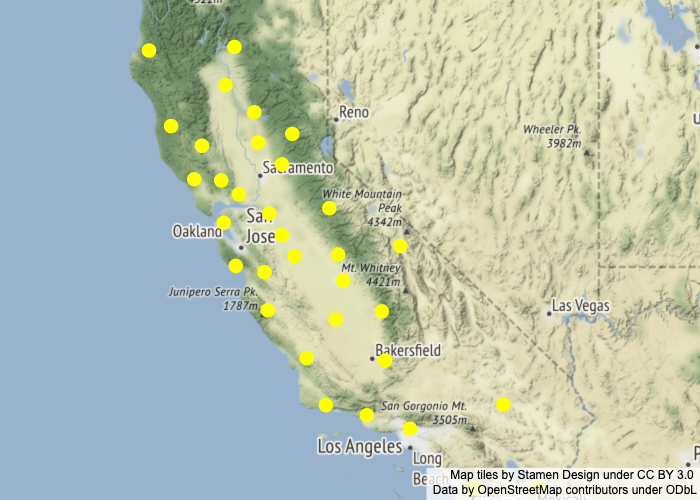

In [7]:
# Grab all the Points.
location_points = db.measurement("locations").all()

# Cast to lists for Plotly.
cbsa_names = [i.tags["cbsa"] for i in location_points]
longitudes = [i.fields["longitude"] for i in location_points]
latitudes = [i.fields["latitude"] for i in location_points]

# Plotly data layer.
data_layer = go.Scattermapbox(
    lat=latitudes,
    lon=longitudes,
    text=cbsa_names,
    mode="markers",
    marker=go.scattermapbox.Marker(size=15, color="yellow"),
)


# Plotly plot layout.
layout = {
    "margin": {"r": 0, "t": 0, "l": 0, "b": 0},
    "height": 600,
    "width": 500,
    "autosize": True,
    "hovermode": "closest",
    "mapbox": dict(
        center={
            "lat": 37.3,
            "lon": -119.5,
        },
        zoom=5,
        style="stamen-terrain",
    ),
}

fig = go.Figure(data=data_layer, layout=layout)
fig.show(None if INTERACTIVE else "png")

## Exploring the Time Series Data: High Level Indicators

Since we have two years of data and our goal is to compare the two years of data, an obviously place to start is with a year over year average.

In [8]:
# Select the non-null AQI values for each year.
aqi_2019 = [i for i in db.select("fields.aqi", q_2019) if i is not None]
aqi_2020 = [i for i in db.select("fields.aqi", q_2020) if i is not None]

# Describe.
print(
    f"The mean AQI in 2019 was {round(statistics.mean(aqi_2019), 1)} "
    f"with a standard deviation of {round(statistics.stdev(aqi_2019), 1)}."
)
print(
    f"The mean AQI in 2020 was {round(statistics.mean(aqi_2020), 1)} "
    f"with a standard deviation of {round(statistics.stdev(aqi_2020), 1)}."
)

The mean AQI in 2019 was 51.8 with a standard deviation of 27.8.
The mean AQI in 2020 was 60.1 with a standard deviation of 39.4.


As we might have expected, the average AQI reading in 2020 was higher than that of 2019 and in fact, it was almost 20% higher.  The stadard deviation also indicates that the range and spread of values was also much greater in 2020 versus 2019.

We might also be interested in the maximum values for each year.

In [9]:
for year, aqi, q in zip(["2019", "2020"], [aqi_2019, aqi_2020], [q_2019, q_2020]):
    print(f"\n{year} top 5 AQIs:")

    top_5_aqis = sorted(aqi)[-5:][::-1]

    for i, value in enumerate(top_5_aqis):

        # Get the point corresponding to the AQI value.
        field_q = Field.aqi == value
        point = db.get(field_q & q)

        print(
            f'  {i + 1} (aqi of {point.fields["aqi"]} on '
            f'{point.time.strftime("%b %d")}): {point.tags["cbsa"]}'
        )


2019 top 5 AQIs:
  1 (aqi of 638 on Oct 09): Bishop, CA
  2 (aqi of 548 on Oct 30): Bakersfield, CA
  3 (aqi of 507 on Oct 27): Hanford-Corcoran, CA
  4 (aqi of 425 on Oct 27): Bishop, CA
  5 (aqi of 356 on Nov 25): Hanford-Corcoran, CA

2020 top 5 AQIs:
  1 (aqi of 684 on Sep 08): Bishop, CA
  2 (aqi of 576 on Jun 05): Riverside-San Bernardino-Ontario, CA
  3 (aqi of 543 on Sep 08): Hanford-Corcoran, CA
  4 (aqi of 458 on Feb 02): Bishop, CA
  5 (aqi of 456 on Sep 09): Ukiah, CA


This jives with [what we know from the news](https://www.sfgate.com/bayarea/article/AQI-Bishop-Creek-Fire-smoke-wildfire-15546975.php#:~:text=Air%20quality%20levels%20worsened%20in,recorded%20an%20AQI%20of%20449.) about the Bishop, CA AQI from September of 2020.  At that time, the amount of PM10 in the atmosphere was at all time record highs due to the effects of 10 separate wildfires around the area, including the devastating Creek Fire.

## A Deep Dive of the Time Series Data: 7 Day Average AQI

Now that we know the AQI was significantly higher across California in 2020, we'll want to explore differences by time.

To accomplish this, we can plot the daily average AQI readings across the state for 2020 against those of 2019.  We'll take the 7 day moving average of these values to get a smoother metric to compare.

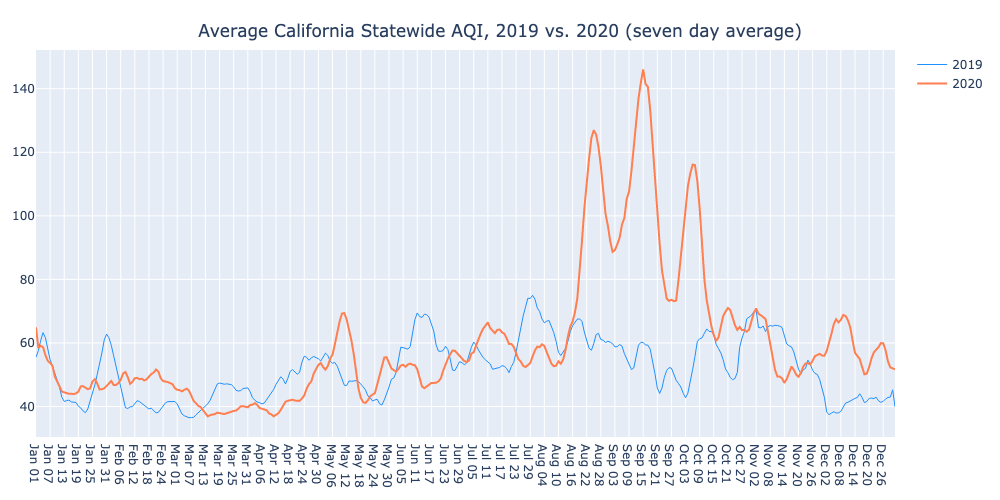

In [10]:
# Get the all timestamps and AQIs for 2019 and 2020.
aqi_2019 = [i for i in db.select(("time", "fields.aqi"), q_2019) if i[1]]
aqi_2020 = [i for i in db.select(("time", "fields.aqi"), q_2020) if i[1]]

# Now we group the observations by day using hash maps.
d1, d2 = {}, {}

for t, aqi in aqi_2019:
    d1[t] = d1[t] + [aqi] if t in d1 else [aqi]

for t, aqi in aqi_2020:
    d2[t] = d2[t] + [aqi] if t in d2 else [aqi]

# We simultaneously calculate the daily averages
# and cast the values to lists for Plotly API.
x, y1, y2 = [], [], []

for i in range(366):
    t1, t2 = jan_1_2019 + timedelta(days=i), jan_1_2020 + timedelta(days=i)

    x.append(t2.strftime("%b %d"))
    y1.append(statistics.mean(d1[t1]) if t1 in d1 else 0)
    y2.append(statistics.mean(d2[t2]) if t2 in d2 else 0)

# Calculate the 7 day moving averages using a helper function.
seven_day_2019 = get_moving_average(y1, 7)
seven_day_2020 = get_moving_average(y2, 7)

# Add the data layers to a Plotly figure and plot.
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x,
        y=seven_day_2019,
        mode="lines",
        name="2019",
        line={
            "color": "dodgerblue",
            "width": 1,
        },
    )
)
fig.add_trace(
    go.Scatter(
        x=x,
        y=seven_day_2020,
        mode="lines",
        name="2020",
        line={
            "color": "coral",
            "width": 2,
        },
    )
)

fig.update_layout(
    title={
        "text": "Average California Statewide AQI, 2019 vs. 2020 (seven day average)",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    width=1000,
    margin=dict(l=20, r=20, t=50, b=30),
)

fig.show(None if INTERACTIVE else "png")

By plotting statewide averages by day, we can clearly see that the AQI was significanly elevated in 2020 versus 2019 from about the middle of August to the middle of October.  This coincides with the peak of the 2020 California wildfire season, a time in which the combination of high wind and dry conditions are prevalent across the Western United States.

## A Deep Dive of the Location Data: AQIs by CBSA across Fire Seasons

The average AQI during fire season in 2019 was 57.8
The average AQI during fire season in 2020 was 87.7


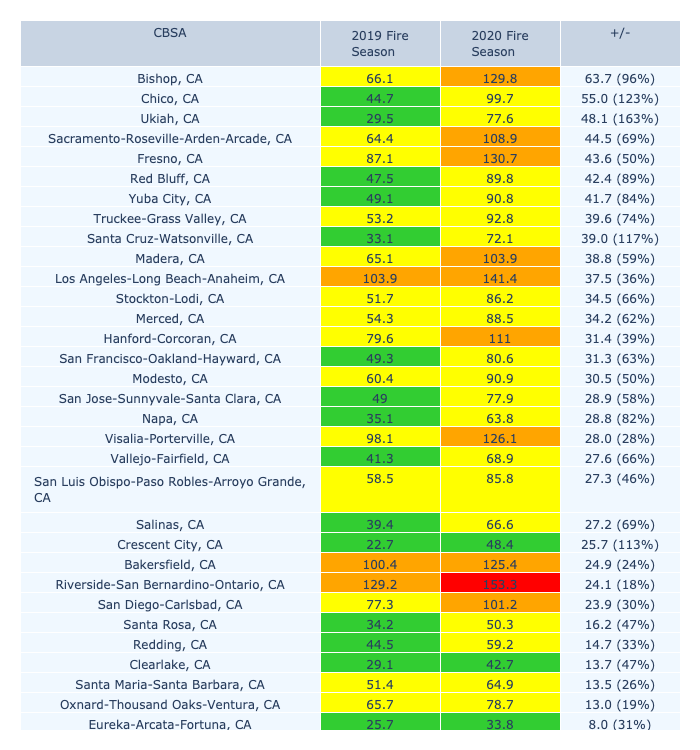

In [11]:
cbsas = db.measurement("aqi").get_tag_values()["cbsa"]
m = db.measurement("aqi")

db_result_2019 = [
    i for i in m.select(("tags.cbsa", "fields.aqi"), q_fire_season_2019) if i[1]
]
db_result_2020 = [
    i for i in m.select(("tags.cbsa", "fields.aqi"), q_fire_season_2020) if i[1]
]

print(
    f"The average AQI during fire season in 2019 was "
    f"{round(statistics.mean([i[1] for i in db_result_2019]), 1)}"
)
print(
    f"The average AQI during fire season in 2020 was "
    f"{round(statistics.mean([i[1] for i in db_result_2020]), 1)}"
)

# Now we group the observations by CBSA using hash maps.
d1, d2 = {k: [] for k in cbsas}, {k: [] for k in cbsas}

for cbsa, aqi in db_result_2019:
    d1[cbsa].append(aqi)

for cbsa, aqi in db_result_2020:
    d2[cbsa].append(aqi)

# We simultaneously calculate the averages
# and cast the values to lists for Plotly API.
x, y1, y2, y3, y4 = cbsas, [], [], [], []

for cbsa in cbsas:
    y1.append(round(statistics.mean(d1[cbsa]), 1))
    y2.append(round(statistics.mean(d2[cbsa]), 1))
    y3.append(round(statistics.mean(d2[cbsa]) - statistics.mean(d1[cbsa]), 1))
    y4.append(int(100 * y3[-1] / y1[-1]))

# Sort these lists by the difference (last column).
x = [i for i, _ in sorted(zip(x, y3), key=lambda x: x[1], reverse=True)]
y1 = [i for i, _ in sorted(zip(y1, y3), key=lambda x: x[1], reverse=True)]
y2 = [i for i, _ in sorted(zip(y2, y3), key=lambda x: x[1], reverse=True)]
y4 = [i for i, _ in sorted(zip(y4, y3), key=lambda x: x[1], reverse=True)]
y3.sort(reverse=True)

datalayer = go.Table(
    columnwidth=[100, 40, 40, 40],
    header=dict(
        values=[
            "CBSA",
            "2019 Fire Season",
            "2020 Fire Season",
            "+/-",
        ]
    ),
    cells={
        "values": [
            x,
            y1,
            y2,
            [f"{i} ({j}%)" for i, j in zip(y3, y4)],
        ],
        "fill_color": [
            ["aliceblue"] * len(x),
            [aqi_color_ramp(i) for i in y1],
            [aqi_color_ramp(i) for i in y2],
            ["aliceblue"] * len(x),
        ],
    },
)

layout = go.Layout(
    margin=dict(l=20, r=20, t=20, b=20),
    height=750,
)
fig = go.Figure(data=datalayer, layout=layout)
fig.update_layout()
fig.show(None if INTERACTIVE else "png")

This table demonstrates that substantial increases in average AQI values during the fire season in 2020 were not limited to any particular area of California.  Every reporting area incurred increases, with most CBSA's exhibiting a greater than 50% increase in AQI values.  While about half of CBSAs (15 of 32) had average readings during the first season in 2019 that were categorized as "Good", this number dropped to just 3 CBSAs in 2020.  Most CBSAs had average readings that were categorized as "Moderate" during 2020, with about a third (9) being "Unhealthy for Sensitive Groups" on average, and the CBSA of Riverside being "Unhealthy" on average, even for the general public.

## Time and Location Together: Animating AQI During the 2020 Fire Season

Finally, we can put time and geolocation together in one chart with the help of an animation.

In [12]:
# Get the CBSAs from the DB.
cbsas = db.measurement("aqi").get_tag_values(["cbsa"])["cbsa"]

# Hash the AQIs by CBSA/timestamp.
data = {}

for cbsa in cbsas:
    q3 = Tag.cbsa == cbsa

    rst = [i for i in db.select(("time", "fields.aqi"), q_2020 & q3) if i[1]]

    for time, aqi in rst:
        data[(cbsa, time)] = aqi

# Prepare the data for Plotly API.
plotly_data = {cbsa: [] for cbsa in cbsas}

for cbsa in cbsas:
    for i in range(366):
        day = jan_1_2020 + timedelta(days=i)

        if (cbsa, day) in data:
            plotly_data[cbsa].append(data[(cbsa, day)])
        elif not len(plotly_data[cbsa]):
            plotly_data[cbsa].append(0)
        else:
            plotly_data[cbsa].append(plotly_data[cbsa][-1])

# Get the location data.
location_points = db.measurement("locations").all()

# Prepare location data for Plotly API.
location_dict = {
    i.tags["cbsa"]: {
        "lat": i.fields["latitude"],
        "lon": i.fields["longitude"],
    }
    for i in location_points
}

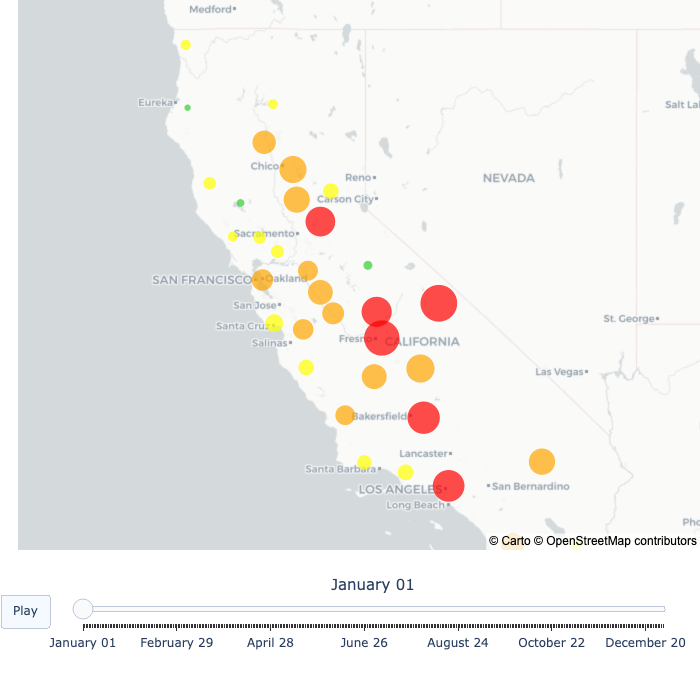

In [13]:
# Init a slider.
sliders = [
    {
        "transition": {"duration": 0},
        "x": 0.08,
        "len": 0.88,
        "currentvalue": {
            "font": {"size": 15},
            "visible": True,
            "xanchor": "center",
        },
        "steps": [
            {
                "label": (jan_1_2020 + timedelta(days=i)).strftime("%B %d"),
                "method": "animate",
                "args": [
                    [f"frame_{i}"],
                    {
                        "mode": "immediate",
                        "frame": {"duration": 100, "redraw": True},
                        "transition": {"duration": 50},
                    },
                ],
            }
            for i in range(366)
        ],
    }
]

# Definte the play button.
play_button = [
    {
        "type": "buttons",
        "showactive": True,
        "x": 0.045,
        "y": -0.08,
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 100, "redraw": True},
                        "transition": {"duration": 100},
                        "fromcurrent": True,
                        "mode": "immediate",
                    },
                ],
            }
        ],
    }
]

frames = [
    {
        "name": f"frame_{i}",
        "data": [
            {
                "type": "scattermapbox",
                "lat": [location_dict[i]["lat"] for i in cbsas],
                "lon": [location_dict[i]["lon"] for i in cbsas],
                "marker": go.scattermapbox.Marker(
                    size=[plotly_data[cbsa][i] / 5 for cbsa in cbsas],
                    color=[aqi_color_ramp(plotly_data[cbsa][i]) for cbsa in cbsas],
                    showscale=False,
                ),
            }
        ],
    }
    for i in range(366)
]


# Defining the initial state
data = frames[250]["data"]

# Add all sliders and play button to the layout.
layout = go.Layout(
    sliders=sliders,
    updatemenus=play_button,
    mapbox={
        "center": {"lat": 37.86, "lon": -120.15},
        "zoom": 5,
        "style": "carto-positron",
    },
    margin={"r": 0, "t": 0, "l": 0, "b": 150},
    height=700,
    width=700,
)

# Creating the figure
fig = go.Figure(
    data=data,
    layout=layout,
    frames=frames,
)

# Displaying the figure
fig.show(None if INTERACTIVE else "png")

This animation demonstrates how drastically and how widespread unhealthy AQIs were during the 2020 fire season, especially when compared to the wet-season

For fun, let's show the same data, but using a heapmap.

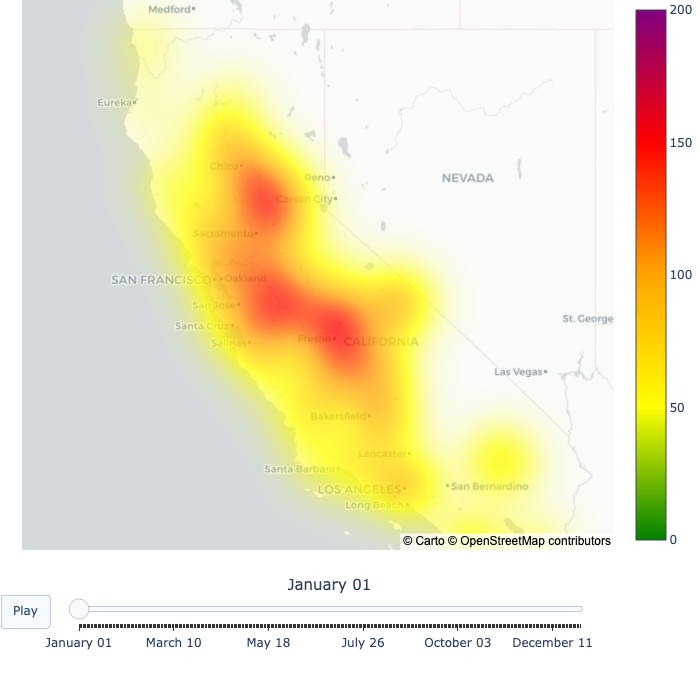

In [14]:
# Init heat map frames.
frames = [
    {
        "name": f"frame_{i}",
        "data": [
            {
                "type": "densitymapbox",
                "lat": [location_dict[i]["lat"] for i in cbsas],
                "lon": [location_dict[i]["lon"] for i in cbsas],
                "z": [plotly_data[cbsa][i] for cbsa in cbsas],
                "showscale": True,
                "radius":80,
                "zmin":0,
                "zmax":200,
                "colorscale":[
                    [0, "green"],
                    [0.25, "yellow"],
                    [0.5, "orange"],
                    [0.75, "red"],
                    [1, "purple"],
    
                ],
                "opacity":0.75
            }
        ],
    }
    for i in range(366)
]

# Defining the initial state
data = frames[250]["data"]

# Adding all sliders and play button to the layout
layout = go.Layout(
    sliders=sliders,
    updatemenus=play_button,
    mapbox={
        "center": {"lat": 37.86, "lon": -120.15},
        "zoom": 5,
        "style": "carto-positron",
    },
    margin={"r": 0, "t": 0, "l": 0, "b": 150},
    height=700,
    width=700,
)

# Creating the figure
fig = go.Figure(data=data, layout=layout, frames=frames, )

# Displaying the figure
fig.show(None if INTERACTIVE else "png")

If you enjoyed this analysis, make sure to fork this repository and download TinyFlux.  Happy analyzing!